## Downloading PyTorch Modular Scripts

In [1]:
import os
from pathlib import Path
import requests

os.chdir("Z:/ML")

base_url = r"https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/going_modular/going_modular"


files = [
    "data_setup.py",
    "engine.py",
    "model_builder.py",
    "predictions.py",
    "train.py",
    "utils.py"]

target_dir = Path("going_modular")

if target_dir.exists():
    print("Already exists!")
else:
    print("Couldn't find, downloading......")
    target_dir.mkdir(exist_ok=True)

    for file_name in files:
        file_url = f"{base_url}/{file_name}"
        response = requests.get(file_url)
        response.raise_for_status()

        file_path = target_dir / file_name
        file_path.write_text(response.text)
        
    print("Downloaded!")

Already exists!


## `download_data()` — Dataset Downloader & Extractor

In [2]:
from pathlib import Path
import os
import requests
import zipfile

os.chdir("Z:/ML")


def download_data(source: str,
                  destination: str,
                  remove_source: bool=True):
    
    data_path = Path("data/")
    image_path = data_path / destination

    if image_path.is_dir():
        print(f"[INFO] {image_path} directory already exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
    
        target_file = Path(source).name
        
        with open(data_path / target_file, "wb") as f:
            response = requests.get(source)
            response.raise_for_status()
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(response.content)
        
        with zipfile.ZipFile(data_path / target_file, 'r') as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)
        
        if remove_source:
            print(f"[INFO] Removing {target_file}...")
            os.remove(data_path / target_file)
    
    return image_path

In [3]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi_10_percent")
image_path

[INFO] data\pizza_steak_sushi_10_percent directory already exists, skipping download.


WindowsPath('data/pizza_steak_sushi_10_percent')

## Dataset Directory Setup

In [4]:
train_dir = image_path / 'train'
test_dir = image_path / "test"

## Manual Image Transformations

In [5]:
from torchvision import transforms
from going_modular import data_setup
import torch

manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## Create DataLoaders for Training and Testing

In [6]:
BATCH_SIZE = 32 

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

## Preview a Single Image and Label from a Batch

In [7]:
image_batch, label_batch = next(iter(train_dataloader))

img, label = image_batch[0], label_batch[0]
img.shape, label

(torch.Size([3, 224, 224]), tensor(1))

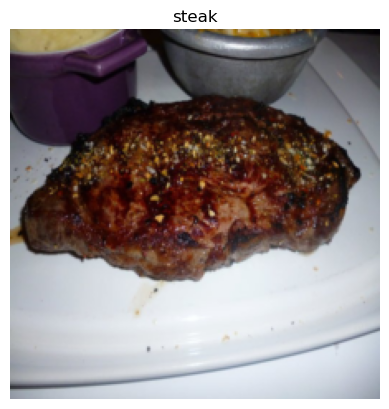

In [8]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## Calculate Number of Patches for ViT

In [9]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16 

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

## Embedding Layer: Input vs Output Shape

In [10]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


## Visualize Image as Patches for Vision Transformer

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


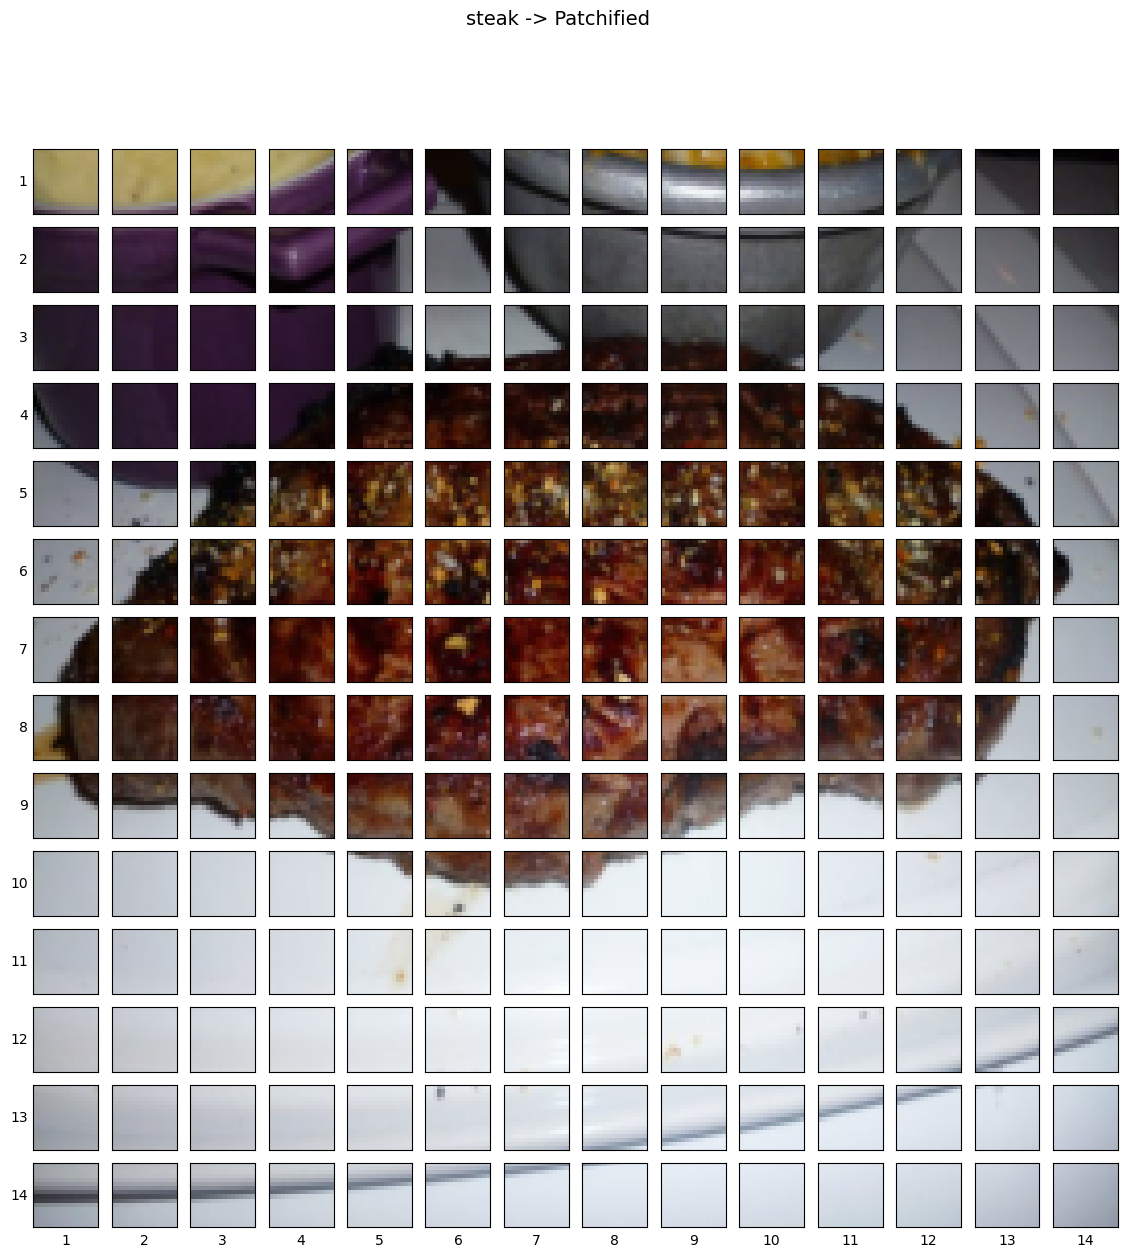

In [11]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
image_permuted = img.permute(1, 2, 0) # convert image to color channels last (H, W, C)


print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axes 
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :]) # get all color channels
    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

## Patch Embedding with `nn.Conv2d`

In [12]:
from torch import nn

patch_size = 16

conv2 = nn.Conv2d(in_channels=3,
                  out_channels=768,
                  kernel_size=patch_size,
                  stride=patch_size,
                  padding=0)

conv2

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [13]:
print(f"input size: {img.unsqueeze(dim=0).shape}")

img_out_of_conv = conv2(img.unsqueeze(dim=0))
print(f"Conv2d: {img_out_of_conv.shape}") # [batch_size, embedding_dim, feature_map_height, feature_map_width]

input size: torch.Size([1, 3, 224, 224])
Conv2d: torch.Size([1, 768, 14, 14])


In [14]:
img_out_of_conv.requires_grad

True

## Plot Random Convolutional Feature Maps (Embeddings)


Showing random convolutional feature maps from indexes: [8, 200, 247, 118, 447]


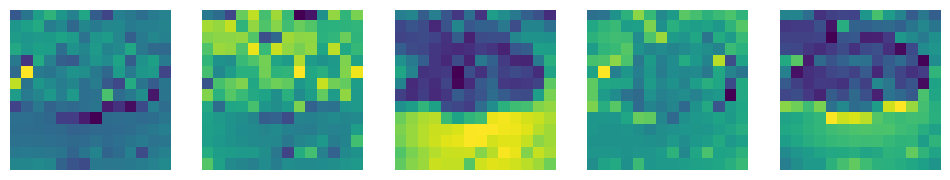

In [15]:
import random

random_idx = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_idx}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_idx):
    img_conv_feature_map = img_out_of_conv[:, idx, :, :]
    axs[i].imshow(img_conv_feature_map.squeeze().detach().numpy())
    axs[i].axis(False)

## Flattening the patch embedding with `torch.nn.Flatten()`

In [16]:
print(f"{img_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


In [17]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flattened = flatten_layer(img_out_of_conv)
print(flattened.shape)

torch.Size([1, 768, 196])


## Patch Embedding Visualization and Tensor Reshaping

Original image shape: torch.Size([3, 224, 224])
image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])
Rearranged dimensions: torch.Size([1, 196, 768])


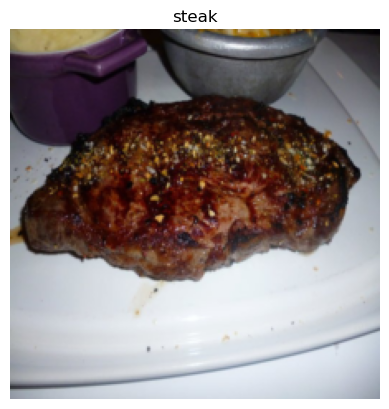

In [18]:
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {img.shape}")

print(f"image feature map (patches) shape: {img_out_of_conv.shape}")

print(f"Flattened image feature map shape: {flatten_layer(img_out_of_conv).shape}")

print(f"Rearranged dimensions: {flatten_layer(img_out_of_conv).permute(0, 2, 1).shape}")

## Visualize a Single Feature Dimension Across All Patches

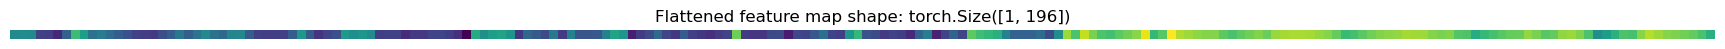

In [19]:
test_feature_map = flatten_layer(img_out_of_conv).permute(0, 2, 1)[:, :, 0]
plt.figure(figsize=(22, 22))

plt.imshow(test_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {test_feature_map.shape}")
plt.axis(False); 


In [20]:
print(f"Input img size: {img.unsqueeze(dim=0).shape}")

patch_embedded_img = flattened.permute(0, 2, 1)
print(f"Output patch embedding sequence shape: {patch_embedded_img.shape}")

Input img size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [21]:
patch_embedded_img

tensor([[[ 0.3639, -0.0046, -0.1624,  ...,  0.6062, -0.0185,  0.0175],
         [ 0.3686, -0.0281, -0.1072,  ...,  0.6258,  0.0094,  0.0336],
         [ 0.3637, -0.0090, -0.0345,  ...,  0.6587, -0.0537,  0.1248],
         ...,
         [ 0.6276, -0.0173, -0.1645,  ...,  0.7339,  0.1427,  0.1578],
         [ 0.5821, -0.0146, -0.1471,  ...,  0.6987,  0.1358,  0.1482],
         [ 0.5091, -0.0128, -0.1195,  ...,  0.6145,  0.1270,  0.1299]]],
       grad_fn=<PermuteBackward0>)

In [22]:
embedding_dimension = patch_embedded_img.shape[-1]
embedding_dimension

768

## Vision Transformer (ViT) — `Paper Highlights`

### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>


### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

### Table 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

## Adding Class Token to Patch Embeddings in Vision Transformer

In [23]:
# 1 represents one [CLS] token per image, not one per patch or per batch
class_token = nn.Parameter(torch.randn(1, 1, embedding_dimension), 
                           requires_grad=True)

#dim=0: batch dimension
#dim=1: sequence length (number of tokens)
#dim=2: embedding dimension

patch_embedded_img_with_token_embedding = torch.cat((class_token, patch_embedded_img),
                                                    dim=1)

print(f"class token shape: {class_token.shape}")
print(f"patch embedded img : {patch_embedded_img.shape}")
print(f"patch embedded img with token embedding : {patch_embedded_img_with_token_embedding.shape}")

class token shape: torch.Size([1, 1, 768])
patch embedded img : torch.Size([1, 196, 768])
patch embedded img with token embedding : torch.Size([1, 197, 768])


## Adding Positional Embedding to Patch + Class Token Sequence

It’s an elementwise addition — each token vector gets its own positional tweak. No new tokens are added, so the shape stays the same

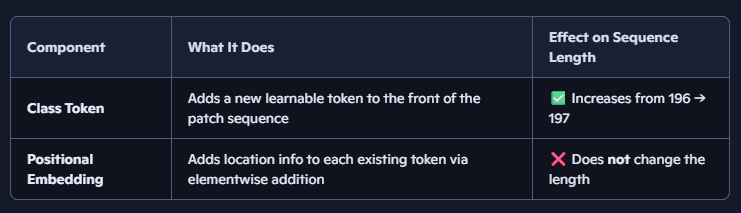

the shape stays the same, but the values inside each token vector change

In [24]:
number_of_patches = int((height * width) / patch_size**2)
embedding_dimension = patch_embedded_img_with_token_embedding.shape[-1]

# +1 -> We need one extra positional embedding for the [CLS] token
# Positional embedding must match the new sequence length: 197
position_embedding = nn.Parameter(torch.randn(1, number_of_patches + 1, embedding_dimension),
                                  requires_grad=True)

patch_embedded_img_with_token_embedding_and_position_embedding = \
patch_embedded_img_with_token_embedding + position_embedding

print(f"class token shape: {class_token.shape}")
print(f"patch embedded img : {patch_embedded_img.shape}")
print(f"patch embedded img with token embedding : {patch_embedded_img_with_token_embedding.shape}")
print(f"patch embedded img with token embedding and position embedding : {patch_embedded_img_with_token_embedding_and_position_embedding.shape}")


class token shape: torch.Size([1, 1, 768])
patch embedded img : torch.Size([1, 196, 768])
patch embedded img with token embedding : torch.Size([1, 197, 768])
patch embedded img with token embedding and position embedding : torch.Size([1, 197, 768])


## `Equation 1`: Vision Transformer Input Embedding 
### `(Patch + Class + Positional Embedding)`

In [25]:
class ViTEmbedding(nn.Module):
    """Converts image to patch embeddings for Vision Transformer."""

    def __init__(self,
                 image_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        
        super().__init__()

        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2

        # Conv2d with kernel_size=stride=patch_size extracts non-overlapping patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # Flatten spatial dimensions (height, width) into sequence length
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, embedding_dim))
    
    
    def forward(self, x):
        height, width = x.shape[2], x.shape[3]
        assert height % self.patch_size == 0 and width % self.patch_size == 0, \
            f"Image size ({height}x{width}) must be divisible by patch size {self.patch_size}"
        
        batch_size = x.shape[0]

        x = self.patcher(x) # (batch, embedding_dim, num_patches_h, num_patches_w)
        x = self.flatten(x) # (batch, embedding_dim, num_total_patches)
        x = x.permute(0, 2, 1) # (batch, num_total_patches, embedding_dim) -> transformer format

        # Expand the first dimension to batch_size, Keep the second and third dimensions unchanged
        cls_token = self.class_token.expand(batch_size, -1, -1) 


        x = torch.cat((cls_token, x), dim=1)

        x = x + self.position_embedding
        return x

In [26]:
vit_embed = ViTEmbedding(image_size=224,
                         in_channels=3,
                         patch_size=16,
                         embedding_dim=768)

print(f"Input img size: {img.unsqueeze(dim=0).shape}")
patch_and_position_embedding = vit_embed(img.unsqueeze(dim=0))
print(f"Output of ViTEmbedding: {patch_and_position_embedding.shape}")

Input img size: torch.Size([1, 3, 224, 224])
Output of ViTEmbedding: torch.Size([1, 197, 768])


## `Equation 2`: Multihead Self-Attention (MSA block)

In [27]:
class MSA_Block(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short)."""
    
    def __init__(self, embedding_dim: int = 768, num_heads: int = 12, attn_dropout: int = 0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=attn_dropout,
                                                   batch_first=True)
    
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [28]:
multihead_self_attention_block = MSA_Block(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## `Equation 3`: Multilayer Perceptron (MLP block)


In [29]:
class MLP_Block(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 dropout: int=0.1):
        
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [30]:
mlp_block = MLP_Block(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## `1.` Custome Transformer Encoder Layer

In [31]:
class Tranformer_Encoder_Block(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads: int=12,
                 mlp_size: int=3072,
                 mlp_dropout: int=0.1,
                 attn_dropout: int=0):
        
        super().__init__()

        self.msa_block = MSA_Block(embedding_dim=embedding_dim,
                                   num_heads=num_heads,
                                   attn_dropout=attn_dropout)
        
        self.mlp_block = MLP_Block(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    
    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [32]:
from torchinfo import summary
transformer_encoder_block = Tranformer_Encoder_Block()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
Tranformer_Encoder_Block (Tranformer_Encoder_Block)     [1, 197, 768]        [1, 197, 768]        --                   True
├─MSA_Block (msa_block)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)              --                   [1, 197, 768]        2,362,368            True
├─MLP_Block (mlp_block)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

### `2.` Transformer Encoder Layer With In-Built Pytorch Layers

In [33]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [34]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## Vision Transformer (ViT) — PyTorch Implementation

In [35]:
class ViT(nn.Module):
    def __init__(self,
                 image_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 num_transformer_layers: int=12,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 num_heads: int=12,
                 attn_dropout: int=0,
                 mlp_dropout: int=0.1,
                 embedding_dropout: int=0.1,
                 num_classes: int=1000
                ):
        super().__init__()

        self.embedding = ViTEmbedding(image_size=image_size,
                                      in_channels=in_channels,
                                      patch_size=patch_size,
                                      embedding_dim=embedding_dim)
        
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        self.encoder = nn.Sequential(*[
            Tranformer_Encoder_Block(embedding_dim=embedding_dim,
                                                num_heads=num_heads,
                                                mlp_size=mlp_size,
                                                mlp_dropout=mlp_dropout,
                                                attn_dropout=attn_dropout,
                                                )
            for _ in range(num_transformer_layers)
        ])

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes))
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.embedding_dropout(x)
        x = self.encoder(x)
        x = self.classifier(x[:, 0])
        return x

In [36]:
from torchinfo import summary

vit_model = ViT()

summary(model=vit_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 1000]            --                   True
├─ViTEmbedding (embedding)                                   [1, 3, 224, 224]     [1, 197, 768]        152,064              True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (encoder)                                       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Tranformer_Encoder_Block (0)                          [1, 197, 768]        [1, 197, 768] 